In [1]:
!date

Thu Sep 28 08:17:06 EDT 2023


In [2]:
pwd

'/mmfs1/data/aglinska/BC-actionpred-seg'

In [3]:
%%time
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random
cudnn.benchmark = True
plt.ion()   # interactive m
from datetime import datetime
now = datetime.now
T0 = now()

from IPython import display
import sys
import seaborn as sns
from IPython import display


CPU times: user 1.33 s, sys: 535 ms, total: 1.87 s
Wall time: 2min 37s


In [4]:
%%time
from torchvision.models import resnet50
from torch.utils.data import Dataset, DataLoader

CPU times: user 6 µs, sys: 2 µs, total: 8 µs
Wall time: 10 µs


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [6]:
def safe_mkdir(fn):
    import os
    if not os.path.exists(fn):
        os.mkdir(fn)

In [7]:
import sys
import psutil
def check_ram():
    try:
        ram_info = psutil.virtual_memory()
        print(f"Total: {ram_info.total / 1024 / 1024 / 1024:.2f} GB")
        print(f"Available: {ram_info.available / 1024 / 1024 / 1024:.2f} GB")
        print(f"Used: {ram_info.used / 1024 / 1024 / 1024:.2f} GB")
        print(f"Percentage usage: {ram_info.percent}%")
    except FileNotFoundError:
        print("Ram info not available on this system")

In [8]:
dataset_path = './Data/pytorch-data/xl_121_15_action_data_orig'

cats = os.listdir(os.path.join(dataset_path,'train'))
cats.sort()
cats = np.array(cats)

n_cats = len(cats)
n_cats

121

In [9]:
indir = os.path.join(dataset_path,'val')
folders = os.listdir(indir)
folders.sort()
folders = np.array(folders)
folder_files = []

files = [os.path.join(indir,folders[0],file) for file in os.listdir(os.path.join(indir,folders[0])) if file.endswith('.jpg')]
files.sort()
folder_files = np.array(files)
for folder in folders[1::]:
    files = [os.path.join(indir,folder,file) for file in os.listdir(os.path.join(indir,folder)) if file.endswith('.jpg')]
    files.sort()
    folder_files = np.hstack((folder_files,files))

frames_lbls_vec_val = np.array([np.argwhere(cats==f.split('/')[-2])[0][0] for f in folder_files])
print(folder_files.shape)
folder_files[0:5]

(6936,)


array(['./Data/pytorch-data/xl_121_15_action_data_orig/val/add_new_car_tire/000_000.jpg',
       './Data/pytorch-data/xl_121_15_action_data_orig/val/add_new_car_tire/000_001.jpg',
       './Data/pytorch-data/xl_121_15_action_data_orig/val/add_new_car_tire/000_002.jpg',
       './Data/pytorch-data/xl_121_15_action_data_orig/val/add_new_car_tire/000_003.jpg',
       './Data/pytorch-data/xl_121_15_action_data_orig/val/add_new_car_tire/000_004.jpg'],
      dtype='<U100')

In [10]:
indir = os.path.join(dataset_path,'train')
folders = os.listdir(indir)
folders.sort()
folders = np.array(folders)
folder_files = []

files = [os.path.join(indir,folders[0],file) for file in os.listdir(os.path.join(indir,folders[0])) if file.endswith('.jpg')]
files.sort()
folder_files = np.array(files)
for folder in folders[1::]:
    files = [os.path.join(indir,folder,file) for file in os.listdir(os.path.join(indir,folder)) if file.endswith('.jpg')]
    files.sort()
    folder_files = np.hstack((folder_files,files))

frames_lbls_vec = np.array([np.argwhere(cats==f.split('/')[-2])[0][0] for f in folder_files])
print(folder_files.shape)
folder_files[0:5]

(95056,)


array(['./Data/pytorch-data/xl_121_15_action_data_orig/train/add_new_car_tire/002_000.jpg',
       './Data/pytorch-data/xl_121_15_action_data_orig/train/add_new_car_tire/002_001.jpg',
       './Data/pytorch-data/xl_121_15_action_data_orig/train/add_new_car_tire/002_002.jpg',
       './Data/pytorch-data/xl_121_15_action_data_orig/train/add_new_car_tire/002_003.jpg',
       './Data/pytorch-data/xl_121_15_action_data_orig/train/add_new_car_tire/002_004.jpg'],
      dtype='<U102')

In [11]:
def divide_chunks(l, n):
    # Yield successive n-sized
    # chunks from l.
    # looping till length l
    for i in range(0, len(l), n): 
        yield l[i:i + n]

## LOAD DATA

In [13]:
# %%time
val_data_flows = np.load('./Data/pytorch-data/flows2/flows3-orig-val-flows.npy')
val_labels_flows = np.load('./Data/pytorch-data/flows2/flows3-orig-val-labels.npy').astype(int)

val_data_frames = np.load('./Data/pytorch-data/DomainNet-frames-val-6936-orig.npy')

print(val_data_flows.shape)
print(val_labels_flows.shape)
print(val_data_frames.shape)

(6300, 2, 224, 224)
(6300,)
(6936, 3, 224, 224)


In [14]:
training_labels_flows = np.load('./Data/pytorch-data/flows2/flows3-orig-train-labels.npy').astype(int)

In [15]:
%%time
training_data_flows = np.load('./Data/pytorch-data/flows2/flows3-orig-train-flows.npy')
training_data_frames = np.load('./Data/pytorch-data/DomainNet-frames-train-95056-orig.npy')

print(training_data_flows.shape)
print(training_data_frames.shape)

(86410, 2, 224, 224)
(95056, 3, 224, 224)
CPU times: user 27 ms, sys: 14.2 s, total: 14.3 s
Wall time: 11min 13s


## END LOAD DATA

In [16]:
frame_chunks = list(divide_chunks(folder_files, 11))
idx_chunks_frames = list(divide_chunks(np.arange(training_data_frames.shape[0]), 11))
idx_chunks_flows = list(divide_chunks(np.arange(training_data_flows.shape[0]), 10))
lbls_chunks = list(divide_chunks(frames_lbls_vec, 11))

In [17]:
def get_batch(batch_size = 32):
    
    choose_cat = np.random.randint(low=0,high=120,size=batch_size)
    
    frames_idx = np.array([np.random.permutation(np.nonzero(frames_lbls_vec==c)[0])[0] for c in choose_cat])
    flows_idx = np.floor((frames_idx/11*10)).astype(int)    
    
    lbls_frames = frames_lbls_vec[frames_idx]
    lbls_flows = training_labels_flows[flows_idx]
    
    batch_frames = training_data_frames[frames_idx,:,:,:]
    batch_flows = training_data_flows[flows_idx,:,:,:]

    return {'lbls_frames' : lbls_frames,
            'lbls_flows' : lbls_flows,
            'batch_frames' : batch_frames,
            'batch_flows' : batch_flows}

In [18]:
def get_batch_val(batch_size = 32):
    
    choose_cat = np.random.randint(low=0,high=120,size=batch_size)
    
    frames_idx = np.array([np.random.permutation(np.nonzero(frames_lbls_vec_val==c)[0])[0] for c in choose_cat])
    flows_idx = np.floor((frames_idx/11*10)).astype(int)    
    
    lbls_frames = frames_lbls_vec_val[frames_idx]
    lbls_flows = val_labels_flows[flows_idx]
    
    batch_frames = val_data_frames[frames_idx,:,:,:]
    batch_flows = val_data_flows[flows_idx,:,:,:]

    return {'lbls_frames' : lbls_frames,
            'lbls_flows' : lbls_flows,
            'batch_frames' : batch_frames,
            'batch_flows' : batch_flows}

In [19]:
batch = get_batch()
[batch[key].shape for key in list(batch.keys())]

[(32,), (32,), (32, 3, 224, 224), (32, 2, 224, 224)]

Text(0.5, 0.92, 'arm_wave')

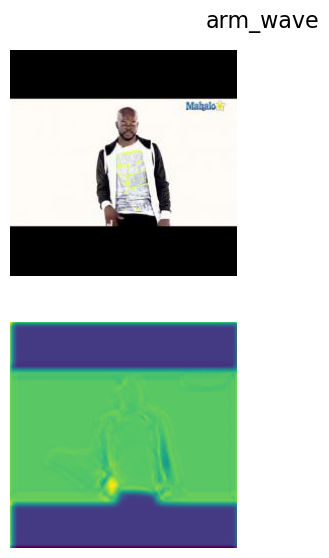

In [21]:
batch = get_batch()
batch.keys()

plt.figure(figsize=(7,10))
plt.subplot(3,2,1);plt.imshow(batch['batch_frames'][0,:,:,:].swapaxes(0,1).swapaxes(2,1).astype(float));plt.axis('off')
plt.subplot(3,2,3);plt.imshow(batch['batch_flows'][0,:,:,:].swapaxes(0,1).swapaxes(2,1).astype(float)[:,:,0] );plt.axis('off')
plt.suptitle(cats[batch['lbls_frames'][0]],y=.92,fontsize=16)

Text(0.5, 0.92, 'rock_balancing')

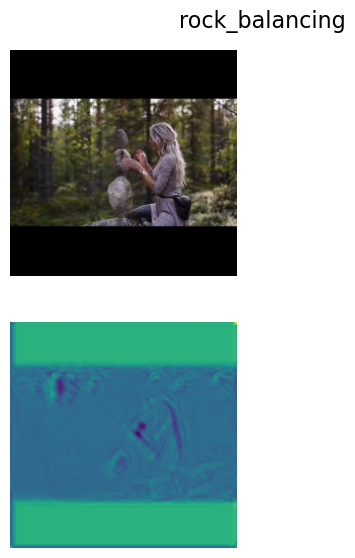

In [22]:
batch = get_batch_val()
batch.keys()

plt.figure(figsize=(7,10))
plt.subplot(3,2,1);plt.imshow(batch['batch_frames'][0,:,:,:].swapaxes(0,1).swapaxes(2,1).astype(float));plt.axis('off')
plt.subplot(3,2,3);plt.imshow(batch['batch_flows'][0,:,:,:].swapaxes(0,1).swapaxes(2,1).astype(float)[:,:,0] );plt.axis('off')
plt.suptitle(cats[batch['lbls_frames'][0]],y=.92,fontsize=16)

In [24]:
staticNet = resnet50()
staticNet.fc = nn.Linear(staticNet.fc.in_features,n_cats)

staticNet.half();
staticNet = staticNet.to(device)

In [26]:
flowNet = resnet50()
flowNet.fc = nn.Linear(flowNet.fc.in_features,n_cats)
flowNet.conv1 = nn.Conv2d(2, 64, kernel_size=7, stride=2, padding=3, bias=False)

flowNet.half();
flowNet = flowNet.to(device)

In [28]:
class CombinedNet(nn.Module):

    def __init__(self,staticNet,flowNet):
        super(CombinedNet, self).__init__()
        self.staticNet = staticNet
        self.flowNet = flowNet

    def forward(self,batch_frames,batch_flows):

        out_frames = self.staticNet( batch_frames )
        out_flows = self.flowNet( batch_flows )
        out_combined = out_frames+out_flows

        return out_frames,out_flows,out_combined

In [29]:
## COMBnet
combinedNet = CombinedNet(staticNet,flowNet)

combinedNet.half()
combinedNet.to(device)

criterion = nn.CrossEntropyLoss()                                 # specify the loss function
optimizer = optim.SGD(combinedNet.parameters(), lr=0.001, momentum=0.9)     # specify the optimizer

In [30]:
save_dir = './Data/pytorch-data/weights/DomainNet_4stream-ORIG-frames-flows'
safe_mkdir(save_dir)

In [31]:
loss_frames = []
loss_flows = []
loss_comb = []
loss_total = []

acc_train_frames = []
acc_train_flows = []
acc_train_comb = []

In [32]:
val_loss_frames = []
val_loss_flows = []
val_loss_comb = []
val_loss_total = []

acc_val_frames = []
acc_val_flows = []
acc_val_comb = []

In [33]:
def do_validation_step():
    combinedNet.eval();
    
    val_chunk_size = 34
    val_chunks = list(divide_chunks(frames_lbls_vec_val,val_chunk_size))
    
    temp_val_top5_acc_frames = 0
    temp_val_top5_acc_flows = 0
    temp_val_top5_acc_combined = 0
    
    temp_val_loss_frames = 0
    temp_val_loss_flows = 0
    temp_val_loss_combined = 0
    temp_val_loss_total = 0
    
    for v in range(len(val_chunks)):
    
        frames_idx = val_chunks[v]
        flows_idx = np.floor((frames_idx/11*10)).astype(int)
        
        lbls_frames = frames_lbls_vec_val[frames_idx]
        lbls_flows = val_labels_flows[flows_idx]
        
        batch_frames = val_data_frames[frames_idx,:,:,:]
        batch_flows = val_data_flows[flows_idx,:,:,:]
        
        batch_lbls = torch.from_numpy(lbls_flows).long()
        batch_frames = torch.from_numpy(batch_frames).half()
        batch_flows = torch.from_numpy(batch_flows).half()
        
        batch_lbls = batch_lbls.cuda()
        batch_frames = batch_frames.cuda()
        batch_flows = batch_flows.cuda()
        
        out_frames,out_flows,out_combined = combinedNet(batch_frames,batch_flows)
        
        temp_val_top5_acc_frames += np.array([lbls_frames[i] in np.argsort(out_frames.detach().cpu().numpy()[i,:])[-1::-1][0:5] for i in range(len(lbls_frames))]).mean()
        temp_val_top5_acc_flows += np.array([lbls_frames[i] in np.argsort(out_flows.detach().cpu().numpy()[i,:])[-1::-1][0:5] for i in range(len(lbls_frames))]).mean()
        temp_val_top5_acc_combined += np.array([lbls_frames[i] in np.argsort(out_combined.detach().cpu().numpy()[i,:])[-1::-1][0:5] for i in range(len(lbls_frames))]).mean()
        
        temp_val_loss_frames += criterion(out_frames, batch_lbls).data.item() 
        temp_val_loss_flows += criterion(out_flows, batch_lbls).data.item() 
        temp_val_loss_combined += criterion(out_combined, batch_lbls).data.item() 
        temp_val_loss_total += temp_val_loss_frames+temp_val_loss_flows+temp_val_loss_combined
    
    val_loss_frames.append( temp_val_loss_frames/v )
    val_loss_flows.append( temp_val_loss_flows/v )
    val_loss_comb.append( temp_val_loss_combined/v )
    val_loss_total.append( temp_val_loss_total/v )
    
    acc_val_frames.append( temp_val_top5_acc_frames/v )
    acc_val_flows.append( temp_val_top5_acc_flows/v )
    acc_val_comb.append( temp_val_top5_acc_combined/v )

    combinedNet.train();

In [34]:
def dashboard():

    if np.mod(epoch,5)==0:
        plt.close()

        
    from IPython import display
    import sys


    display.clear_output(wait=True);
    display.display(plt.gcf());

    
    nrows=4
    ncols = 6
    c = 0
    plt.figure(figsize=(20,10))
    
    c = c+1;plt.subplot(nrows,ncols,c);plt.plot(loss_frames);plt.title('loss_frames')
    c = c+1;plt.subplot(nrows,ncols,c);plt.plot(loss_flows);plt.title('loss_flows')
    c = c+1;plt.subplot(nrows,ncols,c);plt.plot(loss_comb);plt.title('loss_comb')
    c = c+1;plt.subplot(nrows,ncols,c);plt.plot(loss_total);plt.title('loss_total')
    
    c = c+1;plt.subplot(nrows,ncols,c);plt.plot(acc_train_frames);plt.title('acc_train_frames')
    c = c+1;plt.subplot(nrows,ncols,c);plt.plot(acc_train_flows);plt.title('acc_train_flows')
    c = c+1;plt.subplot(nrows,ncols,c);plt.plot(acc_train_comb);plt.title('acc_train_comb');c = c+1;


    c = c+1;plt.subplot(nrows,ncols,c);plt.plot( val_loss_frames );plt.title('val_loss_frames')
    c = c+1;plt.subplot(nrows,ncols,c);plt.plot( val_loss_flows );plt.title('val_loss_flows')
    c = c+1;plt.subplot(nrows,ncols,c);plt.plot( val_loss_comb );plt.title('val_loss_comb')
    c = c+1;plt.subplot(nrows,ncols,c);plt.plot( val_loss_total );plt.title('val_loss_total')

    c = c+1;plt.subplot(nrows,ncols,c);plt.plot( acc_val_frames );plt.title('acc_val_frames')
    c = c+1;plt.subplot(nrows,ncols,c);plt.plot( acc_val_flows );plt.title('acc_val_flows')
    c = c+1;plt.subplot(nrows,ncols,c);plt.plot( acc_val_comb );plt.title('acc_val_comb')

    plt.suptitle(f' epoch {epoch}, T elapsed = {now()-t00}')
    
    plt.tight_layout()
    plt.show()

    sys.stdout.flush()

In [35]:
do_train = False

In [36]:
if do_train==True:
    t00 = now()
    for epoch in tqdm( range(100) ):
        
        epoch_loss_frames = 0
        epoch_loss_flows = 0
        epoch_loss_comb = 0
        epoch_loss_total = 0

        combinedNet.train()
        for b in range(500):
        
            optimizer.zero_grad();

            batch = get_batch()            
    
            batch_lbls = torch.from_numpy(batch['lbls_flows']).long()
            batch_frames = torch.from_numpy(batch['batch_frames']).half()
            batch_flows = torch.from_numpy(batch['batch_flows']).half()
    
            batch_lbls = batch_lbls.cuda()
            batch_frames = batch_frames.cuda()
            batch_flows = batch_flows.cuda()
    
    
            out_frames,out_flows,out_combined = combinedNet(batch_frames,batch_flows)
            
            
            batch_loss_frames = criterion(out_frames, batch_lbls)
            epoch_loss_frames+=batch_loss_frames.data.item() 

    
            batch_loss_flows = criterion(out_flows, batch_lbls)
            epoch_loss_flows+=batch_loss_flows.data.item() 

    
            batch_loss_comb = criterion(out_combined, batch_lbls)
            epoch_loss_comb+=batch_loss_comb.data.item() 
    
            total_loss = batch_loss_frames+batch_loss_flows+batch_loss_comb
        
            epoch_loss_total+=total_loss.data.item() 
            
            assert not np.isnan(epoch_loss_total), 'loss is NaN'
            
            total_loss.backward()
            optimizer.step()
    
        # Collect data end of each epoch
        loss_frames.append( epoch_loss_frames/b )
        loss_flows.append( epoch_loss_flows/b )
        loss_comb.append( epoch_loss_comb/b )
        loss_total.append( epoch_loss_total/b )
    
        acc_train_frames.append( (out_frames.detach().cpu().numpy().argmax(axis=1)==batch_lbls.detach().cpu().numpy()).mean() )
        acc_train_flows.append( (out_flows.detach().cpu().numpy().argmax(axis=1)==batch_lbls.detach().cpu().numpy()).mean() )
        acc_train_comb.append( (out_combined.detach().cpu().numpy().argmax(axis=1)==batch_lbls.detach().cpu().numpy()).mean() )


        
        do_validation_step()
        
        dashboard()

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

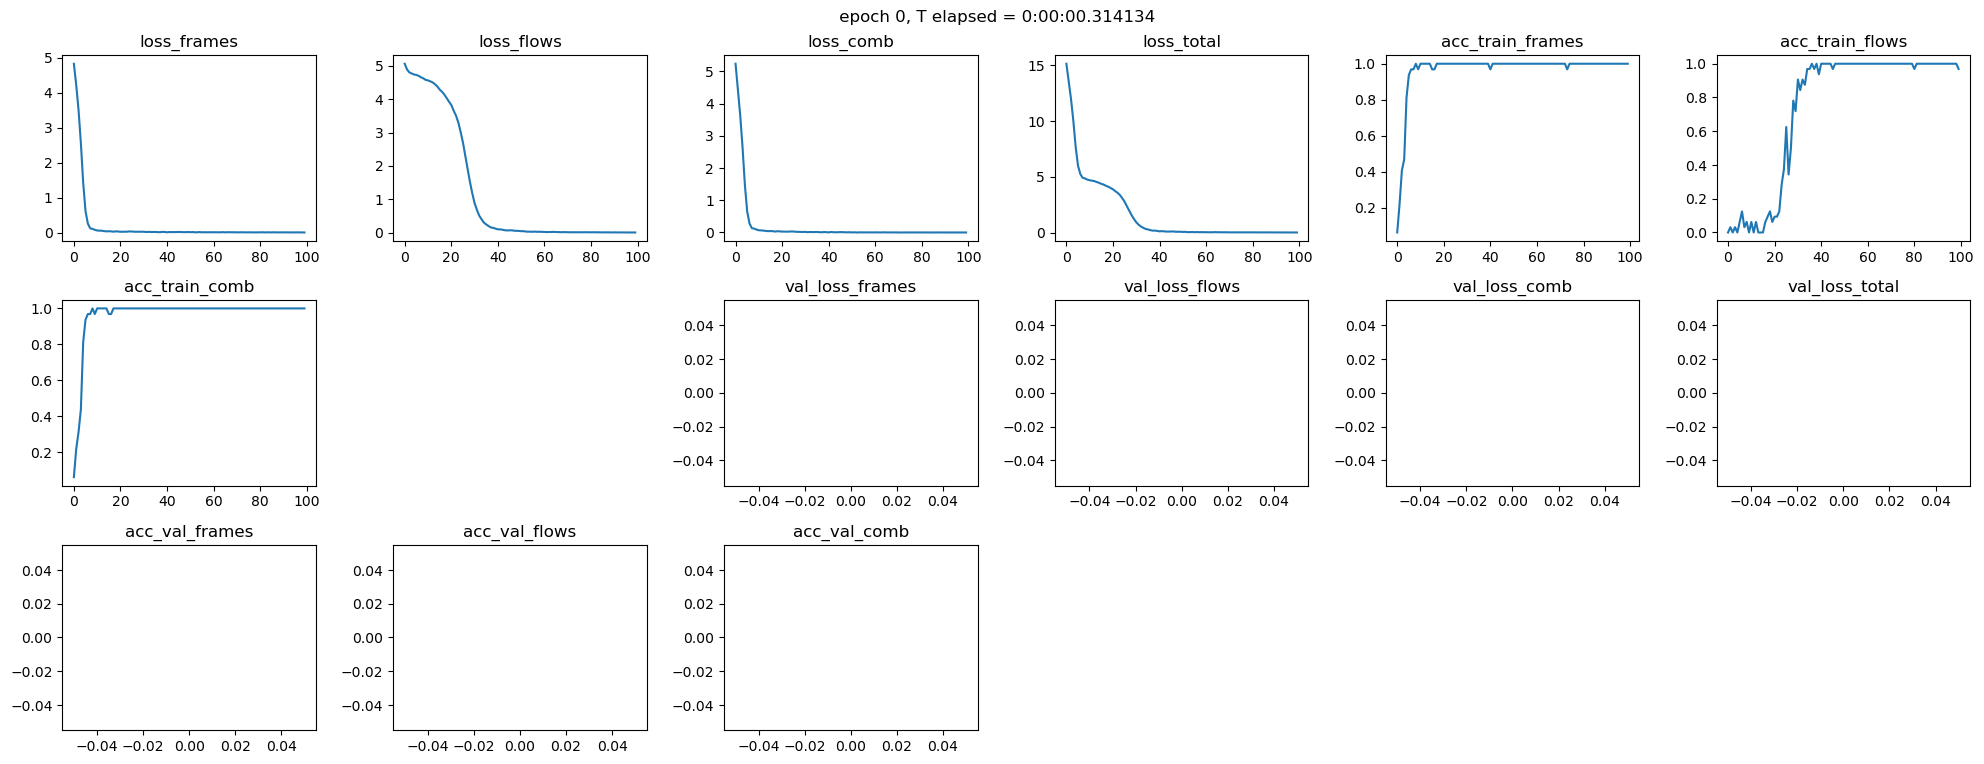

In [37]:
if do_train == True:
    torch.save(combinedNet.state_dict(), os.path.join(save_dir,'weights'))
    np.save(os.path.join(save_dir,'loss_frames.npy'),loss_frames)
    np.save(os.path.join(save_dir,'loss_flows.npy'),loss_flows)
    np.save(os.path.join(save_dir,'loss_comb.npy'),loss_comb)
    np.save(os.path.join(save_dir,'loss_total.npy'),loss_total)
    np.save(os.path.join(save_dir,'acc_train_frames.npy'),acc_train_frames)
    np.save(os.path.join(save_dir,'acc_train_flows.npy'),acc_train_flows)
    np.save(os.path.join(save_dir,'acc_train_comb.npy'),acc_train_comb)
else:
    epoch = 0
    t00 = now()
    loss_frames = np.load(os.path.join(save_dir,'loss_frames.npy'))
    loss_flows = np.load(os.path.join(save_dir,'loss_flows.npy'))
    loss_comb = np.load(os.path.join(save_dir,'loss_comb.npy'))
    loss_total = np.load(os.path.join(save_dir,'loss_total.npy'))
    acc_train_frames = np.load(os.path.join(save_dir,'acc_train_frames.npy'))
    acc_train_flows = np.load(os.path.join(save_dir,'acc_train_flows.npy'))
    acc_train_comb = np.load(os.path.join(save_dir,'acc_train_comb.npy'))

    combinedNet.load_state_dict(torch.load(save_dir+'/weights'))

dashboard()

In [39]:
combinedNet.eval();

In [ ]:
del training_data_flows
del training_labels_flows

del training_data_frames
del training_data_frames

In [42]:
indir = os.path.join(dataset_path,'test')
folders = os.listdir(indir)
folders.sort()
folders = np.array(folders)
folder_files = []

files = [os.path.join(indir,folders[0],file) for file in os.listdir(os.path.join(indir,folders[0])) if file.endswith('.jpg')]
files.sort()
folder_files = np.array(files)
for folder in folders[1::]:
    files = [os.path.join(indir,folder,file) for file in os.listdir(os.path.join(indir,folder)) if file.endswith('.jpg')]
    files.sort()
    folder_files = np.hstack((folder_files,files))

frames_lbls_vec = np.array([np.argwhere(cats==f.split('/')[-2])[0][0] for f in folder_files])
print(folder_files.shape)
folder_files[0:5]

(7697,)


array(['./Data/pytorch-data/xl_121_15_action_data_orig/test/add_new_car_tire/001_000.jpg',
       './Data/pytorch-data/xl_121_15_action_data_orig/test/add_new_car_tire/001_001.jpg',
       './Data/pytorch-data/xl_121_15_action_data_orig/test/add_new_car_tire/001_002.jpg',
       './Data/pytorch-data/xl_121_15_action_data_orig/test/add_new_car_tire/001_003.jpg',
       './Data/pytorch-data/xl_121_15_action_data_orig/test/add_new_car_tire/001_004.jpg'],
      dtype='<U101')

In [43]:
len(folders)

121

In [72]:
%%time
test_data_flows = np.load('./Data/pytorch-data/flows2/flows3-seg-test-flows.npy')
test_labels_flows = np.load('./Data/pytorch-data/flows2/flows3-seg-test-labels.npy').astype(int)
test_data_frames = np.load('./Data/pytorch-data/DomainNet-frames-test-7697-seg.npy')

CPU times: user 12.2 ms, sys: 1.19 s, total: 1.2 s
Wall time: 1min 17s


In [73]:
print(test_data_flows.shape)
print(test_data_frames.shape)

(6990, 2, 224, 224)
(7697, 3, 224, 224)


In [74]:
indir = '/data/aglinska/BC-actionpred-seg/Data/pytorch-data/xl_121_15_action_data_seg/test/'

n = sum([len(os.listdir(os.path.join(indir,f))) for f in os.listdir(indir)])
print(n)

folders = os.listdir(indir)
folders.sort()
folders = np.array(folders)
folder_files = []

files = [os.path.join(indir,folders[0],file) for file in os.listdir(os.path.join(indir,folders[0])) if file.endswith('.jpg')]
files.sort()
folder_files = np.array(files)
for folder in folders[1::]:
    files = [os.path.join(indir,folder,file) for file in os.listdir(os.path.join(indir,folder)) if file.endswith('.jpg')]
    files.sort()
    folder_files = np.hstack((folder_files,files))

print(folder_files.shape)
folder_files[0:5]

7698
(7697,)


array(['/data/aglinska/BC-actionpred-seg/Data/pytorch-data/xl_121_15_action_data_seg/test/add_new_car_tire/001_000.jpg',
       '/data/aglinska/BC-actionpred-seg/Data/pytorch-data/xl_121_15_action_data_seg/test/add_new_car_tire/001_001.jpg',
       '/data/aglinska/BC-actionpred-seg/Data/pytorch-data/xl_121_15_action_data_seg/test/add_new_car_tire/001_002.jpg',
       '/data/aglinska/BC-actionpred-seg/Data/pytorch-data/xl_121_15_action_data_seg/test/add_new_car_tire/001_003.jpg',
       '/data/aglinska/BC-actionpred-seg/Data/pytorch-data/xl_121_15_action_data_seg/test/add_new_car_tire/001_004.jpg'],
      dtype='<U131')

Text(0.5, 0.92, 'quadruped_hip-extension')

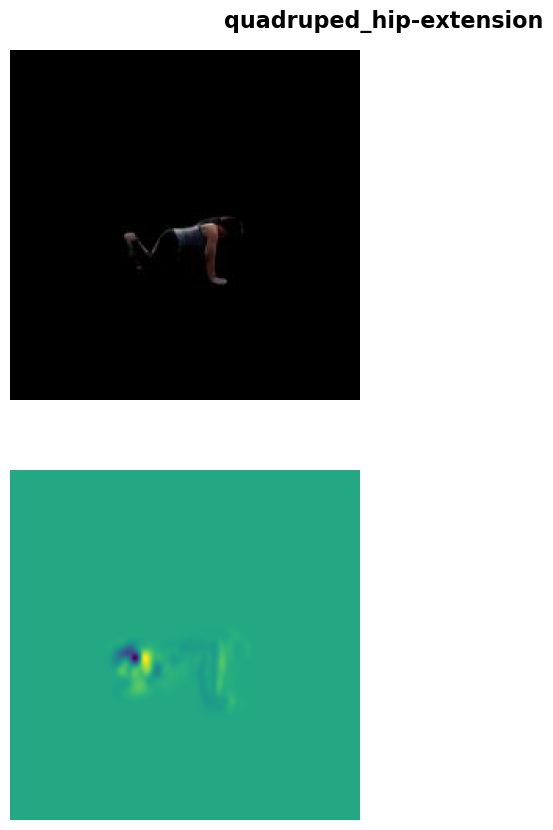

In [76]:
frames_idx = np.random.randint(low=0,high=test_data_frames.shape[0])
flows_idx = np.floor((frames_idx/11*10)).astype(int)

plt.figure(figsize=(10,10))
plt.subplot(2,2,1);plt.imshow(test_data_frames[frames_idx,:,:,:].swapaxes(0,1).swapaxes(2,1).astype(float)[:,:,:]);plt.axis('off')
plt.subplot(2,2,3);plt.imshow(test_data_flows[flows_idx,:,:,:].swapaxes(0,1).swapaxes(2,1).astype(float)[:,:,0]);plt.axis('off')
plt.suptitle(folders[test_labels_flows[flows_idx]],y=.92,fontsize=16,fontweight='bold')

In [77]:
batch_size = 32
test_chunks = list(divide_chunks(np.arange(len(test_data_frames)),batch_size))
n = len(test_chunks)-1


all_outputs_frames = np.zeros((n*batch_size,121))
all_outputs_flows = np.zeros((n*batch_size,121))
all_outputs_combined = np.zeros((n*batch_size,121))
all_lbls_frames = np.zeros(n*batch_size)
all_lbls_flows = np.zeros(n*batch_size)

for i in tqdm(range(n)):
    test_chunk = test_chunks[i]
    idx = np.arange(i*batch_size,i*batch_size+batch_size)
    
    frames_idx = test_chunk
    flows_idx = np.floor((frames_idx/11*10)).astype(int)
    
    lbls_frames = frames_lbls_vec[frames_idx]
    lbls_flows = test_labels_flows[flows_idx]
    
    batch_frames = test_data_frames[frames_idx,:,:,:]
    batch_flows = test_data_flows[flows_idx,:,:,:]

    batch_frames = torch.from_numpy(batch_frames).half()
    batch_flows = torch.from_numpy(batch_flows).half()
    
    batch_frames = batch_frames.cuda()
    batch_flows = batch_flows.cuda()
    
    out_frames,out_flows,out_combined = combinedNet(batch_frames,batch_flows)

    all_outputs_frames[idx,:] = out_frames.detach().cpu().numpy()
    all_outputs_flows[idx,:] = out_flows.detach().cpu().numpy()
    all_outputs_combined[idx,:] = out_combined.detach().cpu().numpy()
    all_lbls_frames[idx] = lbls_frames
    all_lbls_flows[idx] = lbls_flows


100%|█████████████████████████████████████████| 240/240 [00:07<00:00, 31.93it/s]


In [78]:
np.savez_compressed('./ICLR24//DomainFlow-baseline-SEG.npz',
                    all_outputs_frames = all_outputs_frames,
                    all_outputs_flows = all_outputs_flows,
                    all_outputs_combined = all_outputs_combined,
                    all_lbls_frames = all_lbls_frames,
                    all_lbls_flows = all_lbls_flows)

In [51]:
test_lbls = all_lbls_frames

[0.05169270833333333, 0.05364583333333333, 0.07760416666666667]
[0.176171875, 0.18567708333333333, 0.23932291666666666]


Text(0.5, 0.98, '4-Stream DomainNet: test accuracy')

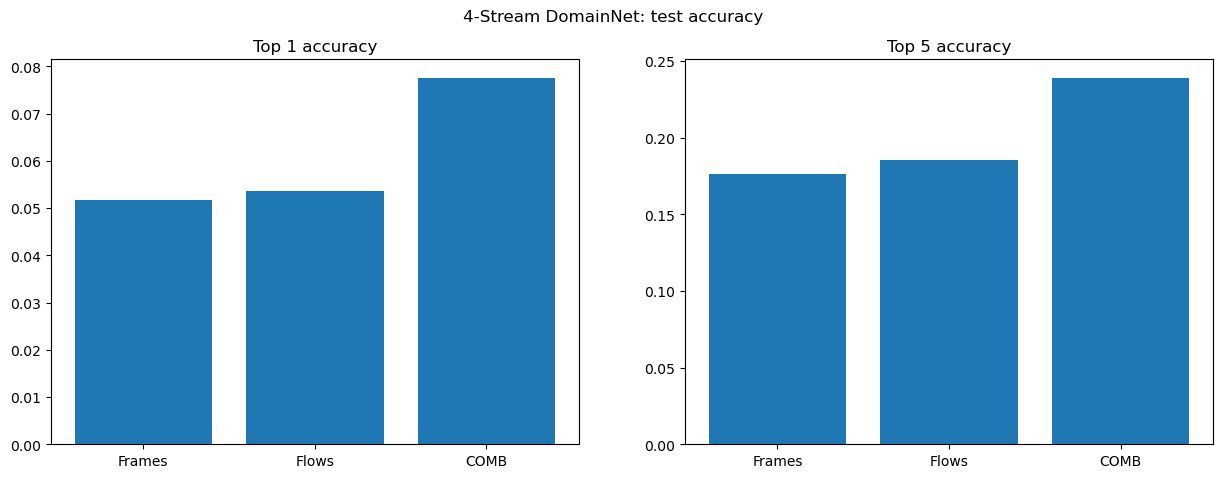

In [52]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)

top1_acc_frames = (all_outputs_frames.argmax(axis=1)==test_lbls).mean()
top1_acc_flows = (all_outputs_flows.argmax(axis=1)==test_lbls).mean()
top1_acc_comb = (all_outputs_combined.argmax(axis=1)==test_lbls).mean()

ys = [top1_acc_frames,top1_acc_flows,top1_acc_comb]
ys_frames_top1 = ys.copy()
print(ys)
xs = np.arange(len(ys))
plt.bar(xs,ys)
lbls = ['Frames','Flows','COMB'];
plt.xticks(xs,labels=lbls);
plt.title('Top 1 accuracy')

plt.subplot(1,2,2)

top = 5
top5_acc_frames = np.array([test_lbls[i] in np.argsort(all_outputs_frames[i,:])[-1::-1][0:top] for i in range(len(test_lbls))]).mean()
top5_acc_flows = np.array([test_lbls[i] in np.argsort(all_outputs_flows[i,:])[-1::-1][0:top] for i in range(len(test_lbls))]).mean()
top5_acc_comb = np.array([test_lbls[i] in np.argsort(all_outputs_combined[i,:])[-1::-1][0:top] for i in range(len(test_lbls))]).mean()

ys = [top5_acc_frames,top5_acc_flows,top5_acc_comb];
ys_frames_top5 = ys.copy()
print(ys)
xs = np.arange(len(ys));
plt.bar(xs,ys);
lbls = ['Frames','Flows','COMB'];
plt.xticks(xs,labels=lbls);
plt.title('Top 5 accuracy')

plt.suptitle('4-Stream DomainNet: test accuracy')